# <b>AASD 4011 - Mathematical Concepts for Deep Learning 2 Group Project</b>

## Zifeng Chen (101411338)
## Siu Fung Chan (101427740)


### Our project aims to develop a deep learning model for facial expression recognition. For this purpose, we have used a dataset that contains folders pertaining to different expressions of the human face, including Surprise, Anger, Happiness, Sad, Neutral, Disgust, and Fear. The dataset is split into two super-folders, Training and Testing, comprising 28,079 and 7,178 samples, respectively. The data consists of 48x48 pixel grayscale images of faces, and the faces have been automatically registered to ensure that they are centered and occupy approximately the same amount of space in each image.

### To improve the performance of the model and prevent overfitting, we have used data augmentation techniques and applied different deep learning machine techniques learnt in previous courses. In addition, we have employed the VGG16 deep learning architecture and tuned the model to accurately predict the emotion of different faces.

### To monitor the usage of model training and familiarize ourselves with different cloud coding platforms, we have chosen to use Google Colab for this project. By utilizing this platform, we were able to effectively control the usage of model training and ensure efficient usage of resources.

### Reference: https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset

In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
import shutil
init_notebook_mode(connected=True)
RANDOM_SEED = 42

In [ ]:
# Unzip the file 
!unzip /content/Validation.zip -d /content/

In [13]:
train = ('./Training/')
test = ('./Testing/')

In [ ]:
# Take a look how many images inside the folder
import os

path = "./Training/"
for subdir, dirs, files in os.walk(path):
    for dir in dirs:
        dir_path = os.path.join(subdir, dir)
        num_files = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print("Number of files in", dir_path, ":", num_files)

Number of files in ./Training/Suprise : 2853
Number of files in ./Training/Neutral : 4468
Number of files in ./Training/Fear : 3687
Number of files in ./Training/Angry : 3595
Number of files in ./Training/Sad : 4347
Number of files in ./Training/Happy : 6493


In [ ]:
path = "./Testing/"
for subdir, dirs, files in os.walk(path):
    for dir in dirs:
        dir_path = os.path.join(subdir, dir)
        num_files = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print("Number of files in", dir_path, ":", num_files)

Number of files in ./Testing/Angry : 958
Number of files in ./Testing/Fear : 1024
Number of files in ./Testing/Happy : 1774
Number of files in ./Testing/Neutral : 1233
Number of files in ./Testing/Sad : 1247
Number of files in ./Testing/Suprise : 831


In [ ]:
# Split 10% of training set as validation set 
train_dir = "./Training"
val_dir = "./Validation"
classes = ["Angry", "Fear", "Happy", "Neutral", "Sad", "Suprise"]

# Create validation directory and subdirectories
os.makedirs(val_dir, exist_ok=True)
for class_name in classes:
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

# Split training data into training and validation sets
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    files = os.listdir(class_dir)
    train_files, val_files = train_test_split(files, test_size=0.1, shuffle=True)

    # Move validation files to validation directory
    for file_name in val_files:
        src_path = os.path.join(class_dir, file_name)
        dst_path = os.path.join(val_dir, class_name, file_name)
        shutil.move(src_path, dst_path)

print("Validation data created successfully!")

Validation data created successfully!


In [ ]:
# New number of image in folder
import os

path = "./Training/"
for subdir, dirs, files in os.walk(path):
    for dir in dirs:
        dir_path = os.path.join(subdir, dir)
        num_files = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print("Number of files in", dir_path, ":", num_files)

Number of files in ./Training/Suprise : 2853
Number of files in ./Training/Neutral : 4468
Number of files in ./Training/Fear : 3687
Number of files in ./Training/Angry : 3595
Number of files in ./Training/Sad : 4347
Number of files in ./Training/Happy : 6493


In [ ]:
import os

path = "./Validation/"
for subdir, dirs, files in os.walk(path):
    for dir in dirs:
        dir_path = os.path.join(subdir, dir)
        num_files = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print("Number of files in", dir_path, ":", num_files)

Number of files in ./Validation/Suprise : 318
Number of files in ./Validation/Neutral : 497
Number of files in ./Validation/Fear : 410
Number of files in ./Validation/Angry : 400
Number of files in ./Validation/Sad : 483
Number of files in ./Validation/Happy : 722


In [14]:
val = ('./Validation/')

In [15]:
# This function will load image data into X, y as classes label in array format, and labels are to classify each class
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [16]:
img_size= (48, 48)

In [17]:
# Output the data to specific variable
X_train, y_train, train_label = load_data(train, img_size)

100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


25443 images loaded from ./Training/ directory.


In [18]:
X_train

array([[[[0.18039216, 0.18039216, 0.18039216],
         [0.05098039, 0.05098039, 0.05098039],
         [0.14117648, 0.14117648, 0.14117648],
         ...,
         [0.07843138, 0.07843138, 0.07843138],
         [0.08235294, 0.08235294, 0.08235294],
         [0.11764706, 0.11764706, 0.11764706]],

        [[0.04705882, 0.04705882, 0.04705882],
         [0.16470589, 0.16470589, 0.16470589],
         [0.20784314, 0.20784314, 0.20784314],
         ...,
         [0.06666667, 0.06666667, 0.06666667],
         [0.08235294, 0.08235294, 0.08235294],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.1882353 , 0.1882353 , 0.1882353 ],
         [0.24313726, 0.24313726, 0.24313726],
         [0.11764706, 0.11764706, 0.11764706],
         ...,
         [0.04705882, 0.04705882, 0.04705882],
         [0.06666667, 0.06666667, 0.06666667],
         [0.07058824, 0.07058824, 0.07058824]],

        ...,

        [[0.01176471, 0.01176471, 0.01176471],
         [0.03137255, 0.03137255, 0.03137255]

In [19]:
y_train

array([0, 0, 0, ..., 5, 5, 5])

In [20]:
train_label

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [21]:
X_val, y_val, val_label = load_data(val, img_size)

100%|██████████| 6/6 [00:00<00:00, 28.62it/s]

2830 images loaded from ./Validation/ directory.


In [22]:
X_test, y_test, test_label = load_data(test, img_size)

100%|██████████| 6/6 [00:00<00:00, 10.89it/s]


7067 images loaded from ./Testing/ directory.


In [23]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

25443
2830
7067


In [ ]:
# Function to plot the images 
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

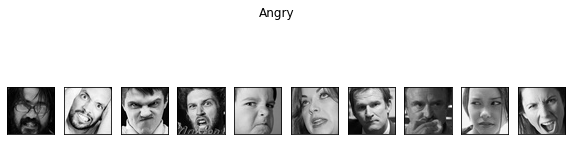

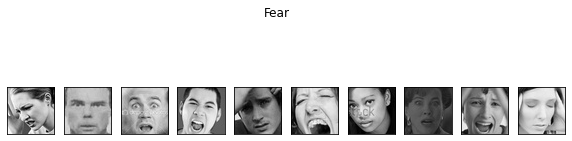

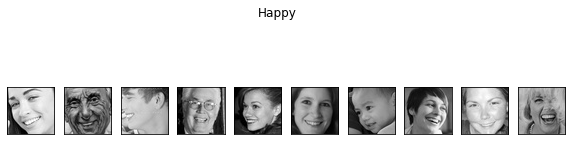

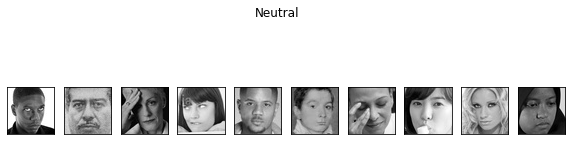

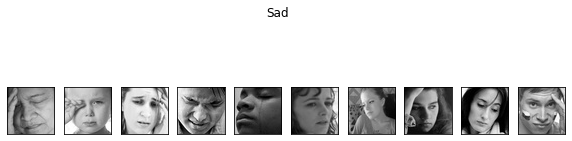

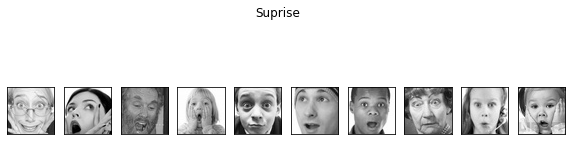

In [ ]:
plot_samples(X_train, y_train, train_label, 10)

In [24]:
# Categorical the train variable to ease the calculation
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(25443, 6)

In [25]:
Y_train

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [26]:
Y_val = to_categorical(y_val, num_classes=6)
Y_val.shape

(2830, 6)

In [27]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(7067, 6)

In [ ]:
# Here we use the VGG-16 architecture to train the model 
from keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights=None,
        include_top=False, 
        input_shape=img_size + (3,)
    )

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# Added a dense layer after flatten and dropout 0.4 to prevent overfitting 
num_class = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(num_class, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1000)              513000    
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 6006      
                                                                 
Total params: 15,233,694
Trainable params: 15,233,694
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def deep_model(model, X_train, Y_train, X_val, Y_val, epochs, batch_size):

    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="vgg16_1.h5",
        save_best_only=True,
        monitor="val_loss")
]
   
    model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])
    
    history = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , verbose=1
                       ,validation_data=(X_val, Y_val)
                       ,callbacks = callbacks)
    return history

In [ ]:
epochs = 20
batch_size = 64

history = deep_model(model, X_train, Y_train, X_val, Y_val, epochs, batch_size)

Epoch 1/20
398/398 [==============================] - 30s 71ms/step - loss: 1.6952 - accuracy: 0.2914 - val_loss: 1.5755 - val_accuracy: 0.3477
Epoch 2/20
398/398 [==============================] - 26s 66ms/step - loss: 1.4485 - accuracy: 0.4169 - val_loss: 1.3460 - val_accuracy: 0.4527
Epoch 3/20
398/398 [==============================] - 27s 67ms/step - loss: 1.3173 - accuracy: 0.4697 - val_loss: 1.2800 - val_accuracy: 0.4682
Epoch 4/20
398/398 [==============================] - 27s 69ms/step - loss: 1.2137 - accuracy: 0.5212 - val_loss: 1.1853 - val_accuracy: 0.5244
Epoch 5/20
398/398 [==============================] - 27s 68ms/step - loss: 1.1333 - accuracy: 0.5535 - val_loss: 1.1722 - val_accuracy: 0.5283
Epoch 6/20
398/398 [==============================] - 26s 66ms/step - loss: 1.0500 - accuracy: 0.5905 - val_loss: 1.1694 - val_accuracy: 0.5406
Epoch 7/20
398/398 [==============================] - 26s 64ms/step - loss: 0.9595 - accuracy: 0.6284 - val_loss: 1.1909 - val_accuracy:

In [ ]:
# Clean the weights and biases
from tensorflow.keras.metrics import Accuracy
accuracy_metric = Accuracy()
accuracy_metric.reset_states()

## Seem we have overfitting problem, lets try to drop the 1000 units dense layer

In [ ]:
num_class = 6

model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(num_class, activation="softmax"))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 14,717,766
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def deep_model2(model2, X_train, Y_train, X_val, Y_val, epochs, batch_size):

    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="vgg16_2.h5",
        save_best_only=True,
        monitor="val_loss",
        )
]
   
    model2.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])
    
    history2 = model2.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , verbose=1
                       ,validation_data=(X_val, Y_val)
                       ,callbacks = callbacks)
    return history2

In [ ]:
epochs = 20
batch_size = 64

history2 = deep_model2(model2, X_train, Y_train, X_val, Y_val, epochs, batch_size)

Epoch 1/20
398/398 [==============================] - 39s 72ms/step - loss: 1.6808 - accuracy: 0.3029 - val_loss: 1.5681 - val_accuracy: 0.3686
Epoch 2/20
398/398 [==============================] - 26s 65ms/step - loss: 1.4172 - accuracy: 0.4369 - val_loss: 1.3167 - val_accuracy: 0.4781
Epoch 3/20
398/398 [==============================] - 27s 67ms/step - loss: 1.2716 - accuracy: 0.4964 - val_loss: 1.2311 - val_accuracy: 0.5191
Epoch 4/20
398/398 [==============================] - 26s 65ms/step - loss: 1.1715 - accuracy: 0.5394 - val_loss: 1.1721 - val_accuracy: 0.5403
Epoch 5/20
398/398 [==============================] - 26s 65ms/step - loss: 1.0830 - accuracy: 0.5755 - val_loss: 1.2150 - val_accuracy: 0.5286
Epoch 6/20
398/398 [==============================] - 26s 66ms/step - loss: 0.9896 - accuracy: 0.6220 - val_loss: 1.1124 - val_accuracy: 0.5664
Epoch 7/20
398/398 [==============================] - 26s 65ms/step - loss: 0.8912 - accuracy: 0.6571 - val_loss: 1.1463 - val_accuracy:

In [ ]:
# Clean the weights and biases
from tensorflow.keras.metrics import Accuracy
accuracy_metric = Accuracy()
accuracy_metric.reset_states()

## After we drop out the 1000 units dense layer, it didn't change much, lets keep the 1000 units dense layer


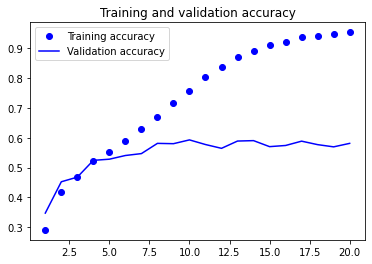

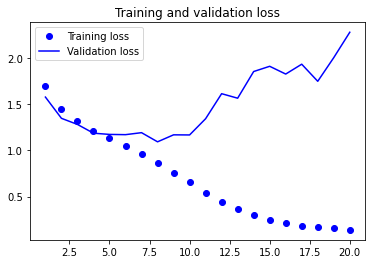

In [ ]:
# To visulize the accuracy and lose
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## As you can see, the test accuracy is around 60%, some labels still misclassified

221/221 [==============================] - 3s 12ms/step
Test Accuracy = 0.58


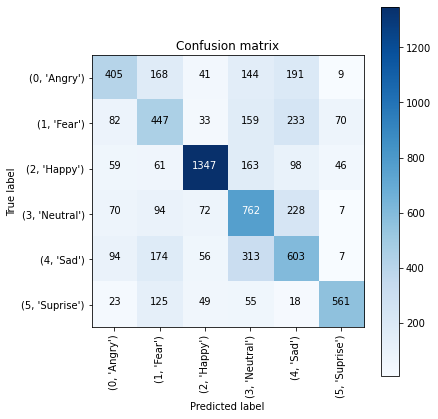

In [ ]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_label.items()), normalize=False)

## Now try to print out some test pictures and see the result

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(test,
                          target_size = (48,48),
                          color_mode = "grayscale",
                          batch_size = batch_size,
                          class_mode = "categorical",
                          shuffle=False)

Found 7067 images belonging to 6 classes.


In [ ]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_label[k] for k in y_pred]

221/221 [==============================] - 2s 11ms/step


In [ ]:
filenames = pred_generator.filenames
actual_class = [test_label[h] for h in pred_generator.classes]

In [ ]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                "Predictions":y_pred,
                "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Angry,Angry
1,Angry/Angry-10.jpg,Angry,Angry
2,Angry/Angry-100.jpg,Sad,Angry
3,Angry/Angry-101.jpg,Fear,Angry
4,Angry/Angry-102.jpg,Angry,Angry


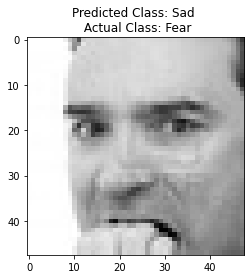

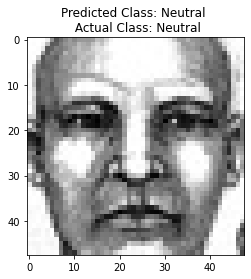

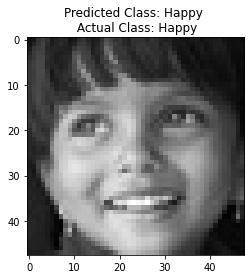

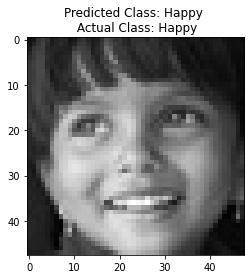

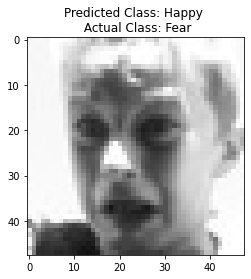

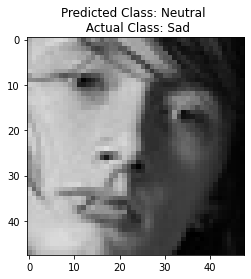

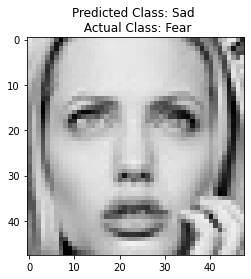

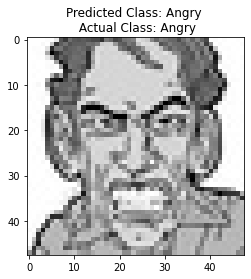

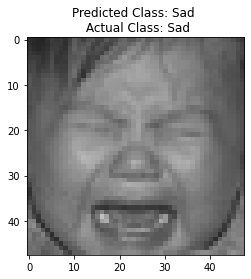

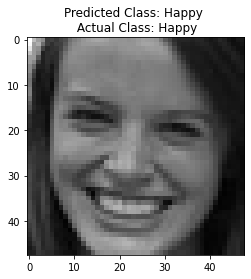

In [ ]:
from random import randint

l = len(filenames)
base_path = test
for i in range(10):  # 10 images
    
    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]
    
    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass

In [3]:
import tensorflow as tf
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='./Training/',
    labels='inferred',
    label_mode='categorical',
    class_names=['Happy', 'Sad', 'Angry', 'Fear', 'Neutral', 'Suprise'],
    color_mode='rgb',
    batch_size=128,
    image_size=(48, 48),
    shuffle=True,
    seed=42,
)

Found 25443 files belonging to 6 classes.


In [4]:
import tensorflow as tf
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='./Validation/',
    labels='inferred',
    label_mode='categorical',
    class_names=['Happy', 'Sad', 'Angry', 'Fear', 'Neutral', 'Suprise'],
    color_mode='rgb',
    batch_size=128,
    image_size=(48, 48),
    shuffle=True,
    seed=42,
)

Found 2830 files belonging to 6 classes.


In [29]:
import tensorflow as tf
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='./Testing/',
    labels='inferred',
    label_mode='categorical',
    class_names=['Happy', 'Sad', 'Angry', 'Fear', 'Neutral', 'Suprise'],
    color_mode='rgb',
    batch_size=128,
    image_size=(48, 48),
    shuffle=True,
    seed=42,
)

Found 7067 files belonging to 6 classes.


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

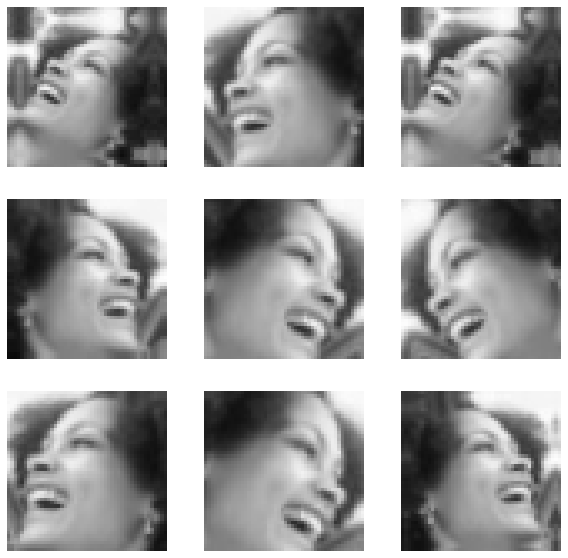

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Next, we want to implement data augmentation to see there is any changes

In [7]:
from keras.applications.vgg16 import VGG16
num_class = 6

# this is data augmentation 
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


base_model = VGG16(
        weights=None,
        include_top=False  
    )

inputs = keras.Input(shape=(48, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_class, activation="softmax")(x)
model3 = keras.Model(inputs, outputs)
model3.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 48, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 48, 48, 3)        0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                             

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="vgg16_3.h5",
        save_best_only=True,
        monitor="val_loss")
]
history3 = model3.fit(
    train_dataset,
    epochs=20,
    batch_size=128,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20


199/199 [==============================] - 178s 811ms/step - loss: 6.9173 - accuracy: 0.2532 - val_loss: 1.7589 - val_accuracy: 0.2551
Epoch 2/20
199/199 [==============================] - 162s 814ms/step - loss: 1.7877 - accuracy: 0.2540 - val_loss: 1.7584 - val_accuracy: 0.2551
Epoch 3/20
199/199 [==============================] - 164s 825ms/step - loss: 1.7590 - accuracy: 0.2546 - val_loss: 1.7559 - val_accuracy: 0.2551
Epoch 4/20
199/199 [==============================] - 164s 822ms/step - loss: 1.7508 - accuracy: 0.2544 - val_loss: 1.7593 - val_accuracy: 0.2551
Epoch 5/20
199/199 [==============================] - 164s 825ms/step - loss: 1.7418 - accuracy: 0.2545 - val_loss: 1.7293 - val_accuracy: 0.2551
Epoch 6/20
199/199 [==============================] - 164s 823ms/step - loss: 1.7166 - accuracy: 0.2703 - val_loss: 1.7556 - val_accuracy: 0.2671
Epoch 7/20
199/199 [==============================] - 163s 817ms/step - loss: 1.6597 - accuracy: 0.3009 - val_loss: 3.6152 - val_accura

In [ ]:
# Clean the weights and biases
from tensorflow.keras.metrics import Accuracy
accuracy_metric = Accuracy()
accuracy_metric.reset_states()

# After running the data augmentation, 20 epoches seem didn't well train the model, let change epoch size to 40 and adam optimizer to get higher accuracy

In [ ]:
from keras.applications.vgg16 import VGG16
num_class = 6

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


base_model = VGG16(
        weights=None,
        include_top=False  
    )

inputs = keras.Input(shape=(48, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_class, activation="softmax")(x)
model4 = keras.Model(inputs, outputs)
model4.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 48, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 48, 48, 3)        0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                             

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="vgg16_4.h5",
        save_best_only=True,
        monitor="val_loss")
]
history4 = model4.fit(
    train_dataset,
    epochs=40,
    batch_size=128,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40


199/199 [==============================] - 252s 1s/step - loss: 1.8296 - accuracy: 0.2504 - val_loss: 1.7566 - val_accuracy: 0.2551
Epoch 2/40
199/199 [==============================] - 235s 1s/step - loss: 1.7474 - accuracy: 0.2543 - val_loss: 1.7324 - val_accuracy: 0.2551
Epoch 3/40
199/199 [==============================] - 232s 1s/step - loss: 1.7225 - accuracy: 0.2626 - val_loss: 1.6840 - val_accuracy: 0.2908
Epoch 4/40
199/199 [==============================] - 232s 1s/step - loss: 1.6558 - accuracy: 0.3020 - val_loss: 1.6067 - val_accuracy: 0.3187
Epoch 5/40
199/199 [==============================] - 228s 1s/step - loss: 1.5957 - accuracy: 0.3329 - val_loss: 1.4384 - val_accuracy: 0.3943
Epoch 6/40
199/199 [==============================] - 231s 1s/step - loss: 1.4811 - accuracy: 0.3976 - val_loss: 1.3504 - val_accuracy: 0.4686
Epoch 7/40
199/199 [==============================] - 230s 1s/step - loss: 1.3869 - accuracy: 0.4434 - val_loss: 1.4235 - val_accuracy: 0.4459
Epoch 8/40

## We are trying to run more epoches to get a precise accuracy, however, the google colab terminated the process because of long running time. We can see the accuracy still going up, so increasing the running epoch will improve the result. Also, we find that the training accuracy and validation accuracy are pretty close, which means after using data augementation, we solve the overfitting problem, the model can well predict the picture. In next session, I will polt the result from model 3.



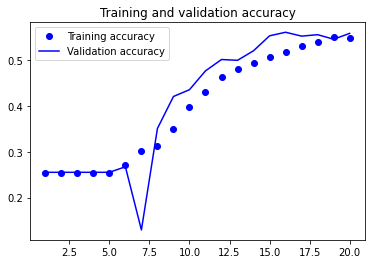

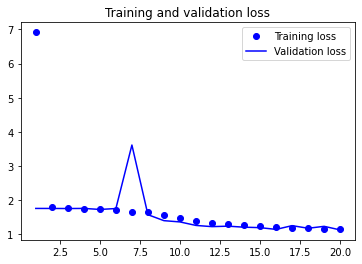

In [10]:
import matplotlib.pyplot as plt
accuracy = history3.history["accuracy"]
val_accuracy = history3.history["val_accuracy"]
loss = history3.history["loss"]
val_loss = history3.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [32]:
test_model = keras.models.load_model("vgg16_3.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

56/56 [==============================] - 1s 8ms/step - loss: 1.1396 - accuracy: 0.5584
Test accuracy: 0.558


### Conclusion: We experimented with different model architectures by adding and removing dense layers. We also applied data augmentation to increase the number of training images and improve the model performance. However, we noticed that some of the images in our dataset (less than 10 in the training set) were totally blank and white, which might affect the test accuracy negatively. Moreover, the dataset consisted of 48*48 grayscale images, which had low resolution, no color channels, and even difficult for us to classify it, which might also limit the model accuracy.